---
title: Adversarial Attacks - Arjun Bhagoji - IITGN Talk
author: "Arjun Nitin Bhagoji"
date: "2024-02-16"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "output.png"
categories: ["Adversarial"]

---

## Data, model and attack utilities

The colab environment already has all the necessary Python packages installed. Specifically, we are using *numpy*, *torch* and *torchvision*.



In [3]:
import os
import time

import numpy as np
import torch

import argparse
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [4]:
# Choosing backend
if torch.backends.mps.is_available():
    device=torch.device("mps")
elif torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

### Loading data

We load in the data using the in-built data loaders in PyTorch. It offers functionality for many commonly used computer vision datasets, but we will just use MNIST (a dataset of black and white handwritten digits) for now.

In [5]:
def load_dataset(dataset, data_dir, training_time):
    if dataset == 'CIFAR-10':
        loader_train, loader_test, data_details = load_cifar_dataset(data_dir, training_time)
    elif 'MNIST' in dataset:
        loader_train, loader_test, data_details = load_mnist_dataset(data_dir, training_time)
    else:
        raise ValueError('No support for dataset %s' % args.dataset)

    return loader_train, loader_test, data_details


def load_mnist_dataset(data_dir, training_time):
    # MNIST data loaders
    trainset = datasets.MNIST(root=data_dir, train=True,
                                download=True, transform=transforms.ToTensor())
    testset = datasets.MNIST(root=data_dir, train=False,
                                download=True, transform=transforms.ToTensor())

    loader_train = torch.utils.data.DataLoader(trainset,
                                batch_size=128,
                                shuffle=True)

    loader_test = torch.utils.data.DataLoader(testset,
                                batch_size=128,
                                shuffle=False)
    data_details = {'n_channels':1, 'h_in':28, 'w_in':28, 'scale':255.0}
    return loader_train, loader_test, data_details

Having defined the data loaders, we now create the data loaders to be used throughout, as well as a dictionary with the details of the dataset, in case we need it.

In [7]:
loader_train, loader_test, data_details = load_dataset('MNIST','data',training_time=True)

100%|██████████| 9912422/9912422 [00:04<00:00, 2104403.41it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1426854.82it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1837670.12it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17117.92it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Common path and definitions for train/test

Since we need the path to the directory where we will storing our models (pre-trained or not), and we also need to instantiate a copy of the model we defined above, we will run the following commands to have everything setup for test/evaluation.

### Defining the model

We use a 2-layer fully connected network for the experiments in this tutorial. The definition of a 3 layer convolutional neural network is also provided. The former is sufficient for MNIST, but may not be large enough for more complex tasks.

In [8]:
model_name='fcn'

In [9]:
class cnn_3l_bn(nn.Module):
    def __init__(self, n_classes=10):
        super(cnn_3l_bn, self).__init__()
        #in-channels, no. filters, filter size, stride
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.bn2 = nn.BatchNorm2d(50)
        # Number of neurons in preceding layer, Number in current layer
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x):
        # Rectified linear unit activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class fcn(nn.Module):
  def __init__(self, n_classes=10):
    super(fcn, self).__init__()
    self.fc1 = nn.Linear(784,200)
    self.fc2 = nn.Linear(200,200)
    self.fc3 = nn.Linear(200,n_classes)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [10]:
if 'fcn' in model_name:
  model_dir_name='models'+'/'+'MNIST'+'/fcn/'
  if not os.path.exists(model_dir_name):
    os.makedirs(model_dir_name)

  # Basic setup
  net = fcn(10)
elif 'cnn' in model_name:
  model_dir_name='models'+'/'+'MNIST'+'/cnn_3l_bn/'
  if not os.path.exists(model_dir_name):
    os.makedirs(model_dir_name)

  # Basic setup
  net = cnn_3l_bn(10)

net.to(device)

criterion = nn.CrossEntropyLoss(reduction='none')

## Training the benign/standard model
This is sample code for training your own model. Since it takes time to run, for the purposes of the tutorial, we will assume we already have trained models.

In [11]:
########################################  Benign/standard training ########################################
def train_one_epoch(model, optimizer, loader_train, verbose=True):
    losses = []
    model.train()
    for t, (x, y) in enumerate(loader_train):
        x.to(device)
        y.to(device)
        x_var = Variable(x, requires_grad= True).to(device)
        y_var = Variable(y, requires_grad= False).to(device)
        scores = model(x_var)
        # loss = loss_fn(scores, y_var)
        loss_function = nn.CrossEntropyLoss(reduction='none')
        batch_loss = loss_function(scores, y_var)
        loss = torch.mean(batch_loss)
        losses.append(loss.data.cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        # print(model.conv1.weight.grad)
        optimizer.step()
    if verbose:
        print('loss = %.8f' % (loss.data))
    return np.mean(losses)

### Actual training loop

We define the necessary parameters for training (batch size, learning rate etc.), instantiate the optimizer and then train for 50 epochs.

In each epoch, the model is trained using all of the training data, which is split into batches of size 128. Thus, one step of the optimizer uses 128 samples, and there are a total of 50*(50,000/128) steps in the entire process.

In [12]:
# Training parameters
batch_size=128
learning_rate=0.1 #
weight_decay=2e-4
save_checkpoint=True

# Torch optimizer
optimizer = torch.optim.SGD(net.parameters(),
                            lr=learning_rate,
                            momentum=0.9,
                            weight_decay=weight_decay)

# if args.lr_schedule == 'cosine':
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
#             T_max=args.train_epochs, eta_min=0, last_epoch=-1)
# elif args.lr_schedule == 'linear0':
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150,200], gamma=0.1)

In [13]:
for epoch in range(0, 10):
    start_time = time.time()
    # lr = update_hyparam(epoch, args)
    lr = optimizer.param_groups[0]['lr']
    print('Current learning rate: {}'.format(lr))
    # if not args.is_adv:
    ben_loss = train_one_epoch(net, optimizer,
                          loader_train, verbose=False)
    print('time_taken for #{} epoch = {:.3f}'.format(epoch+1, time.time()-start_time))
    if save_checkpoint:
        ckpt_path = 'checkpoint_' + str(0)
        torch.save(net.state_dict(), model_dir_name + ckpt_path)
    print('Train loss - Ben: %s' %
        (ben_loss))
    scheduler.step()

Current learning rate: 0.1
time_taken for #1 epoch = 7.601
Train loss - Ben: 0.31587338
Current learning rate: 0.1
time_taken for #2 epoch = 4.716
Train loss - Ben: 0.10687091
Current learning rate: 0.1
time_taken for #3 epoch = 4.632
Train loss - Ben: 0.077742085
Current learning rate: 0.1
time_taken for #4 epoch = 4.658
Train loss - Ben: 0.059824426
Current learning rate: 0.1
time_taken for #5 epoch = 4.724
Train loss - Ben: 0.048329774
Current learning rate: 0.1
time_taken for #6 epoch = 4.784
Train loss - Ben: 0.04214269
Current learning rate: 0.1
time_taken for #7 epoch = 4.817
Train loss - Ben: 0.036589097
Current learning rate: 0.1
time_taken for #8 epoch = 4.708
Train loss - Ben: 0.031158488
Current learning rate: 0.1
time_taken for #9 epoch = 4.671
Train loss - Ben: 0.028846452
Current learning rate: 0.1
time_taken for #10 epoch = 4.596
Train loss - Ben: 0.027309908


## Generating Adversarial Examples
We will look at how to generate adversarial examples using the Projected Gradient Descent (PGD) method for the model we have trained and visualize the adversarial examples thus generated.

In [14]:
# Attack utils

# Random initialization within the L2 ball
def rand_init_l2(img_variable, eps_max):
    random_vec = torch.FloatTensor(*img_variable.shape).normal_(0, 1).to(device)
    random_vec_norm = torch.max(
               random_vec.view(random_vec.size(0), -1).norm(2, 1), torch.tensor(1e-9).to(device))
    random_dir = random_vec/random_vec_norm.view(random_vec.size(0),1,1,1)
    random_scale = torch.FloatTensor(img_variable.size(0)).uniform_(0, eps_max).to(device)
    random_noise = random_scale.view(random_vec.size(0),1,1,1)*random_dir
    img_variable = Variable(img_variable.data + random_noise, requires_grad=True).to(device)

    return img_variable

# Random initialization within the L_inf ball
def rand_init_linf(img_variable, eps_max):
    random_noise = torch.FloatTensor(*img_variable.shape).uniform_(-eps_max, eps_max).to(device)
    img_variable = Variable(img_variable.data + random_noise, requires_grad=True).to(device)

    return img_variable

# Tracking the best adversarial examples during the generation process
def track_best(blosses, b_adv_x, curr_losses, curr_adv_x):
    if blosses is None:
        b_adv_x = curr_adv_x.clone().detach()
        blosses = curr_losses.clone().detach()
    else:
        replace = curr_losses < blosses
        b_adv_x[replace] = curr_adv_x[replace].clone().detach()
        blosses[replace] = curr_losses[replace]

    return blosses.to(device), b_adv_x.to(device)

# Loss calculation
def cal_loss(y_out, y_true, targeted):
    losses = torch.nn.CrossEntropyLoss(reduction='none')
    losses_cal = losses(y_out, y_true).to(device)
    loss_cal = torch.mean(losses_cal).to(device)
    if targeted:
        return loss_cal, losses_cal
    else:
        return -1*loss_cal, -1*losses_cal

# Generating targets for each adversarial example
def generate_target_label_tensor(true_label, n_classes):
    t = torch.floor(n_classes*torch.rand(true_label.shape)).type(torch.int64)
    m = t == true_label
    t[m] = (t[m]+ torch.ceil((n_classes-1)*torch.rand(t[m].shape)).type(torch.int64)) % n_classes
    return t.to(device)

This provides the core loop of the attack algorithm which goes as follows:
1. The perturbation is initialized to 0.
2. The gradient of the model with respect to the current state of the adversarial example is found.
3. The gradient is appropriately normalized and added to the current state of the example
4. The complete adversarial example is clipped to lie within the input bounds
5. Steps 2,3 and 4 are repeated for a fixed number of steps or until some condition is met

In [15]:
# Attack code
def pgd_attack(model, image_tensor, img_variable, tar_label_variable,
               n_steps, eps_max, eps_step, clip_min, clip_max, targeted, rand_init):
    """
    image_tensor: tensor which holds the clean images.
    img_variable: Corresponding pytorch variable for image_tensor.
    tar_label_variable: Assuming targeted attack, this variable holds the targeted labels.
    n_steps: number of attack iterations.
    eps_max: maximum l_inf attack perturbations.
    eps_step: l_inf attack perturbation per step
    """

    best_losses = None
    best_adv_x = None
    image_tensor = image_tensor.to(device)

    if rand_init:
        img_variable = rand_init_linf(img_variable, eps_max)

    output = model.forward(img_variable)
    for i in range(n_steps):
        if img_variable.grad is not None:
            img_variable.grad.zero_()
        output = model.forward(img_variable)
        loss_cal, losses_cal = cal_loss(output, tar_label_variable, targeted)
        best_losses, best_adv_x = track_best(best_losses, best_adv_x, losses_cal, img_variable)

        loss_cal, losses_cal = cal_loss(output, tar_label_variable, targeted)
        loss_cal.backward()
        # Finding the gradient of the loss
        x_grad = -1 * eps_step * torch.sign(img_variable.grad.data)
        # Adding gradient to current state of the example
        adv_temp = img_variable.data + x_grad
        total_grad = adv_temp - image_tensor
        total_grad = torch.clamp(total_grad, -eps_max, eps_max)
        x_adv = image_tensor + total_grad
        # Projecting adversarial example back onto the constraint set
        x_adv = torch.clamp(torch.clamp(
            x_adv-image_tensor, -1*eps_max, eps_max)+image_tensor, clip_min, clip_max)
        img_variable.data = x_adv

    best_losses, best_adv_x = track_best(best_losses, best_adv_x, losses_cal, img_variable)

    return best_adv_x

def pgd_l2_attack(model, image_tensor, img_variable, tar_label_variable,
               n_steps, eps_max, eps_step, clip_min, clip_max, targeted,
               rand_init, num_restarts):
    """
    image_tensor: tensor which holds the clean images.
    img_variable: Corresponding pytorch variable for image_tensor.
    tar_label_variable: Assuming targeted attack, this variable holds the targeted labels.
    n_steps: number of attack iterations.
    eps_max: maximum l_inf attack perturbations.
    eps_step: l_inf attack perturbation per step
    """

    best_losses = None
    best_adv_x = None
    image_tensor_orig = image_tensor.clone().detach()
    tar_label_orig = tar_label_variable.clone().detach()

    for j in range(num_restarts):
        if rand_init:
            img_variable = rand_init_l2(img_variable, eps_max)

        output = model.forward(img_variable)
        for i in range(n_steps):
            if img_variable.grad is not None:
                img_variable.grad.zero_()
            output = model.forward(img_variable)
            loss_cal, losses_cal = cal_loss(output, tar_label_variable, targeted)
            best_losses, best_adv_x = track_best(best_losses, best_adv_x, losses_cal, img_variable)
            loss_cal.backward()
            raw_grad = img_variable.grad.data
            grad_norm = torch.max(
                   raw_grad.view(raw_grad.size(0), -1).norm(2, 1), torch.tensor(1e-9))
            grad_dir = raw_grad/grad_norm.view(raw_grad.size(0),1,1,1)
            adv_temp = img_variable.data +  -1 * eps_step * grad_dir
            # Clipping total perturbation
            total_grad = adv_temp - image_tensor
            total_grad_norm = torch.max(
                   total_grad.view(total_grad.size(0), -1).norm(2, 1), torch.tensor(1e-9))
            total_grad_dir = total_grad/total_grad_norm.view(total_grad.size(0),1,1,1)
            total_grad_norm_rescale = torch.min(total_grad_norm, torch.tensor(eps_max))
            clipped_grad = total_grad_norm_rescale.view(total_grad.size(0),1,1,1) * total_grad_dir
            x_adv = image_tensor + clipped_grad
            x_adv = torch.clamp(x_adv, clip_min, clip_max)
            img_variable.data = x_adv

        best_losses, best_adv_x = track_best(best_losses, best_adv_x, losses_cal, img_variable)

        diff_array = np.array(x_adv.cpu())-np.array(image_tensor.data.cpu())
        diff_array = diff_array.reshape(len(diff_array),-1)

        img_variable.data = image_tensor_orig

    return best_adv_x

Now we can call the core adversarial example generation function over our data and model to determine how robust the model actually is!

In [16]:
def robust_test(model, loss_fn, loader, att_dir, n_batches=0, train_data=False,
                training_time=False):
    """
    n_batches (int): Number of batches for evaluation.
    """
    model.eval()
    num_correct, num_correct_adv, num_samples = 0, 0, 0
    steps = 1
    losses_adv = []
    losses_ben = []
    adv_images = []
    adv_labels = []
    clean_images = []
    correct_labels = []

    for t, (x, y) in enumerate(loader):
        x=x.to(device)
        y=y.to(device)
        x_var = Variable(x, requires_grad= True).to(device)
        y_var = Variable(y, requires_grad=False).to(device)
        if att_dir['targeted']:
            y_target = generate_target_label_tensor(
                               y_var.cpu(), 10).to(device)
        else:
            y_target = y_var
        if 'PGD_linf' in att_dir['attack']:
            adv_x = pgd_attack(model, x, x_var, y_target, att_dir['attack_iter'],
                           att_dir['epsilon'], att_dir['eps_step'], att_dir['clip_min'],
                           att_dir['clip_max'], att_dir['targeted'], att_dir['rand_init'])
        elif 'PGD_l2' in att_dir['attack']:
            adv_x = pgd_l2_attack(model, x, x_var, y_target, att_dir['attack_iter'],
                           att_dir['epsilon'], att_dir['eps_step'], att_dir['clip_min'],
                           att_dir['clip_max'], att_dir['targeted'], att_dir['rand_init'],
                           att_dir['num_restarts'])
        # Predictions
        # scores = model(x.cuda())
        scores = model(x)
        _, preds = scores.data.max(1)
        scores_adv = model(adv_x)
        _, preds_adv = scores_adv.data.max(1)
        # Losses
        batch_loss_adv = loss_fn(scores_adv, y)
        loss_adv = torch.mean(batch_loss_adv)
        losses_adv.append(loss_adv.data.cpu().numpy())
        batch_loss_ben = loss_fn(scores, y)
        loss_ben = torch.mean(batch_loss_ben)
        losses_ben.append(loss_ben.data.cpu().numpy())
        # Correct count
        num_correct += (preds == y).sum()
        num_correct_adv += (preds_adv == y).sum()
        num_samples += len(preds)
        # Adding images and labels to list
        adv_images.extend(adv_x)
        adv_labels.extend(preds_adv)
        clean_images.extend(x)
        correct_labels.extend(preds)

        if n_batches > 0 and steps==n_batches:
            break
        steps += 1

    acc = float(num_correct) / num_samples
    acc_adv = float(num_correct_adv) / num_samples
    print('Clean accuracy: {:.2f}% ({}/{})'.format(
        100.*acc,
        num_correct,
        num_samples,
    ))
    print('Adversarial accuracy: {:.2f}% ({}/{})'.format(
        100.*acc_adv,
        num_correct_adv,
        num_samples,
    ))

    return 100.*acc, 100.*acc_adv, np.mean(losses_ben), np.mean(losses_adv), adv_images, adv_labels, clean_images, correct_labels

The most important parameters below are epsilon (which controls the magnitude of the perturbation), gamma (which determines how far outside the constraint set intial search is allowed) and attack_iter (which is just the number of attack iterations).

In [17]:
# Attack setup
gamma=2.5
epsilon=0.2
attack_iter=10
delta=epsilon*gamma/attack_iter
attack_params = {'attack': 'PGD_linf', 'epsilon': epsilon,
              'attack_iter': 10, 'eps_step': delta,
              'targeted': True, 'clip_min': 0.0,
              'clip_max': 1.0,'rand_init': True,
              'num_restarts': 1}

Now, we load the model (**remember to first upload it into the models folder!**) and then generate adversarial examples.

In [18]:
ckpt_path = 'checkpoint_' + str(0)
net.to(device)
net.eval()
net.load_state_dict(torch.load(model_dir_name + ckpt_path, map_location=device))
n_batches_eval = 10
print('Test set validation')
# Running validation
acc_test, acc_adv_test, test_loss, test_loss_adv, adv_images, adv_labels, clean_images, correct_labels = robust_test(net,
    criterion, loader_test, attack_params, n_batches=n_batches_eval,
    train_data=False, training_time=True)
# print('Training set validation')
# acc_train, acc_adv_train, train_loss, train_loss_adv, _ = robust_test(net,
#     criterion, loader_train_all, args, attack_params, n_batches=n_batches_eval,
#     train_data=True, training_time=True)

Test set validation
Clean accuracy: 97.50% (1248/1280)
Adversarial accuracy: 6.95% (89/1280)


### Visualizing the adversarial examples

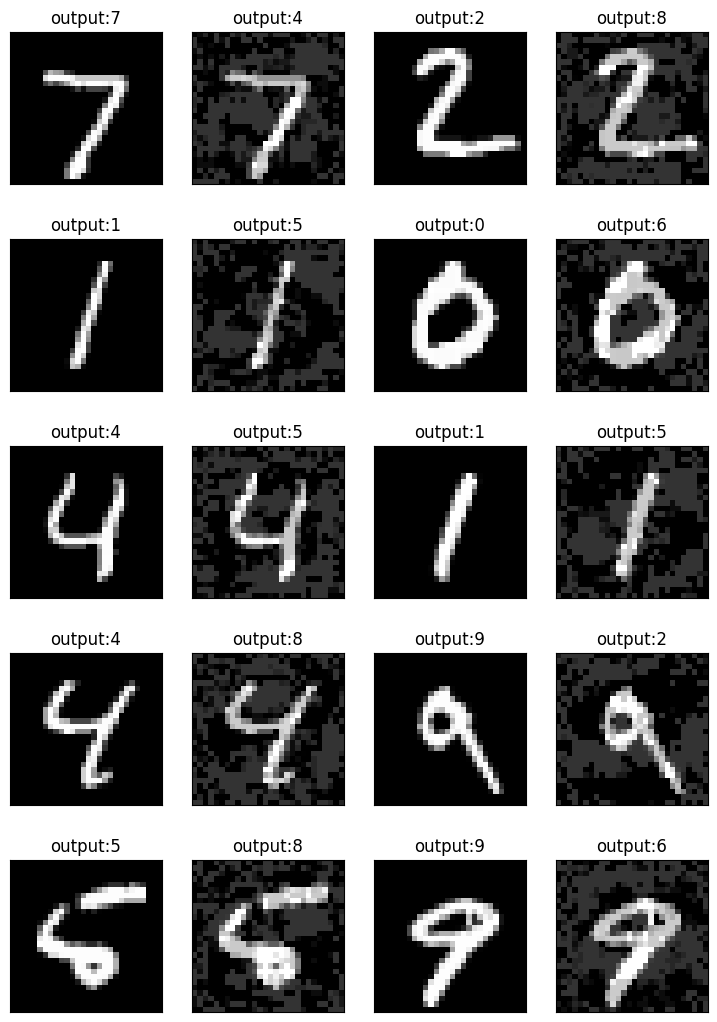

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image_count=int(i/2)
    if i%2==1:
      img = adv_images[image_count].reshape(28,28).cpu()
      # create subplot and append to ax
      ax.append( fig.add_subplot(rows, columns, i+1) )
      ax[-1].set_title("output:"+str(adv_labels[image_count].cpu().numpy()))  # set title
      ax[-1].set_xticks([])
      ax[-1].set_yticks([])
    else:
      img = clean_images[image_count].reshape(28,28).cpu()
      # create subplot and append to ax
      ax.append( fig.add_subplot(rows, columns, i+1) )
      ax[-1].set_title("output:"+str(correct_labels[image_count].cpu().numpy()))  # set title
      ax[-1].set_xticks([])
      ax[-1].set_yticks([])
    plt.imshow(img, interpolation='nearest',cmap='gray')


plt.show()  # finally, render the plot


## Training robust models

This training loop is very similar to the benign one, except that we now call the adversarial example generation function to generate adversarial examples during the training process.

In [20]:
########################################  Adversarial training ########################################
def robust_train_one_epoch(model, optimizer, loader_train, att_dir,
                           epoch):
    # print('Current eps: {}, delta: {}'.format(eps, delta))
    losses_adv = []
    losses_ben = []
    model.train()
    for t, (x, y) in enumerate(loader_train):
        x=x.to(device)
        y=y.to(device)
        x_var = Variable(x, requires_grad= True)
        y_var = Variable(y, requires_grad= False)
        if att_dir['targeted']:
            y_target = generate_target_label_tensor(
                               y_var.cpu(), 10).to(device)
        else:
            y_target = y_var
        if 'PGD_linf' in att_dir['attack']:
            adv_x = pgd_attack(model, x, x_var, y_target, att_dir['attack_iter'],
                           att_dir['epsilon'], att_dir['eps_step'], att_dir['clip_min'],
                           att_dir['clip_max'], att_dir['targeted'], att_dir['rand_init'])
        elif 'PGD_l2' in att_dir['attack']:
            adv_x = pgd_l2_attack(model, x, x_var, y_target, att_dir['attack_iter'],
                           att_dir['epsilon'], att_dir['eps_step'], att_dir['clip_min'],
                           att_dir['clip_max'], att_dir['targeted'], att_dir['rand_init'],
                           att_dir['num_restarts'])
        scores = model(adv_x)
        loss_function = nn.CrossEntropyLoss(reduction='none')
        batch_loss_adv = loss_function(scores, y_var)
        batch_loss_ben = loss_function(model(x),y_var)
        loss = torch.mean(batch_loss_adv)
        loss_ben = torch.mean(batch_loss_ben)
        losses_ben.append(loss_ben.data.cpu().numpy())
        losses_adv.append(loss.data.cpu().numpy())
        # GD step
        optimizer.zero_grad()
        loss.backward()
        # print(model.conv1.weight.grad)
        optimizer.step()
    return np.mean(losses_adv), np.mean(losses_ben)

In [21]:
for epoch in range(0, 10):
    start_time = time.time()
    # lr = update_hyparam(epoch, args)
    lr = optimizer.param_groups[0]['lr']
    print('Current learning rate: {}'.format(lr))
    curr_loss, ben_loss = robust_train_one_epoch(net,
                            optimizer, loader_train, attack_params,
                            epoch)
    print('time_taken for #{} epoch = {:.3f}'.format(epoch+1, time.time()-start_time))
    if save_checkpoint:
        ckpt_path = 'checkpoint_adv' + str(0)
        torch.save(net.state_dict(), model_dir_name + ckpt_path)
    print('Train loss - Ben: %s, Adv: %s' %
        (ben_loss, curr_loss))
    scheduler.step()

Current learning rate: 0.1
time_taken for #1 epoch = 37.619
Train loss - Ben: 0.22832306, Adv: 0.8869703
Current learning rate: 0.1
time_taken for #2 epoch = 35.834
Train loss - Ben: 0.1525188, Adv: 0.6310392
Current learning rate: 0.1
time_taken for #3 epoch = 35.815
Train loss - Ben: 0.13646857, Adv: 0.5643174
Current learning rate: 0.1
time_taken for #4 epoch = 37.486
Train loss - Ben: 0.12810308, Adv: 0.5258196
Current learning rate: 0.1
time_taken for #5 epoch = 36.946
Train loss - Ben: 0.12174366, Adv: 0.5080386
Current learning rate: 0.1
time_taken for #6 epoch = 39.277
Train loss - Ben: 0.11583303, Adv: 0.4890312
Current learning rate: 0.1
time_taken for #7 epoch = 36.914
Train loss - Ben: 0.11223529, Adv: 0.4611834
Current learning rate: 0.1
time_taken for #8 epoch = 36.823
Train loss - Ben: 0.11202868, Adv: 0.45640397
Current learning rate: 0.1
time_taken for #9 epoch = 36.936
Train loss - Ben: 0.10568718, Adv: 0.4513212
Current learning rate: 0.1
time_taken for #10 epoch = 3

## Evaluating the robust model

Evaluating the robust model, we find its accuracy on adversarial examples has increased significantly!

In [22]:
ckpt_path = 'checkpoint_adv' + str(0)
net.eval()
net.load_state_dict(torch.load(model_dir_name + ckpt_path, map_location=device))
n_batches_eval = 10
print('Test set validation')
# Running validation
acc_test_r, acc_adv_test_r, test_loss_r, test_loss_adv_r, adv_images_r, adv_labels_r, clean_images_r, correct_labels_r = robust_test(net,
    criterion, loader_test, attack_params, n_batches=n_batches_eval,
    train_data=False, training_time=True)
# print('Training set validation')
# acc_train, acc_adv_train, train_loss, train_loss_adv, _ = robust_test(net,
#     criterion, loader_train_all, args, attack_params, n_batches=n_batches_eval,
#     train_data=True, training_time=True)

Test set validation
Clean accuracy: 95.94% (1228/1280)
Adversarial accuracy: 85.08% (1089/1280)


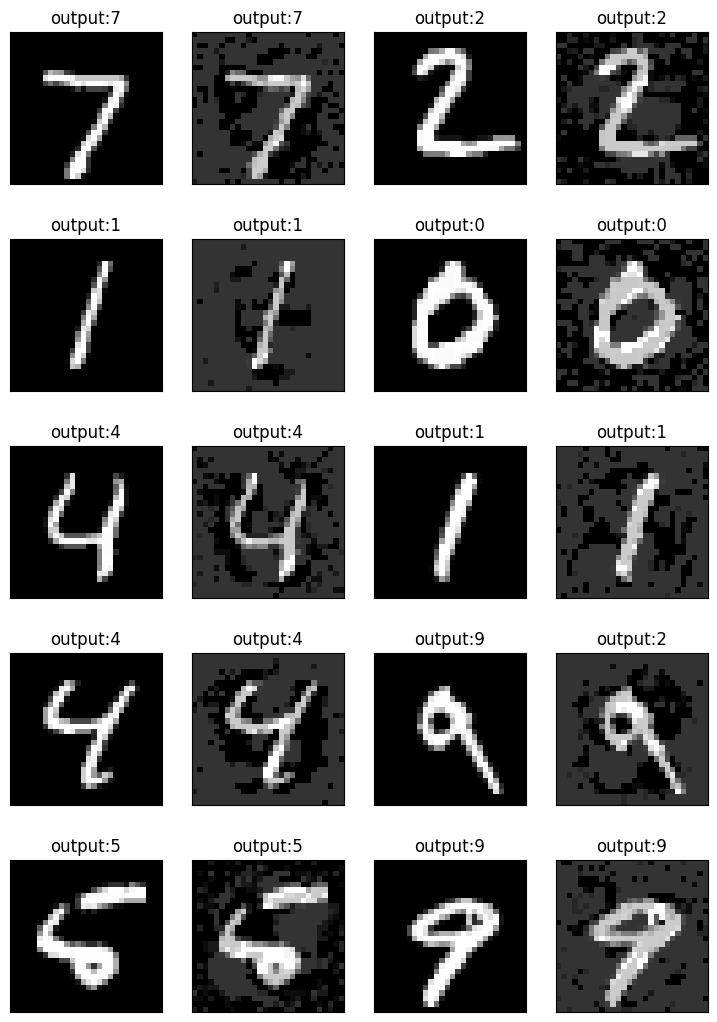

In [23]:
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image_count=int(i/2)
    if i%2==1:
      img = adv_images_r[image_count].reshape(28,28).cpu()
      # create subplot and append to ax
      ax.append( fig.add_subplot(rows, columns, i+1) )
      ax[-1].set_title("output:"+str(adv_labels_r[image_count].cpu().numpy()))  # set title
      ax[-1].set_xticks([])
      ax[-1].set_yticks([])
    else:
      img = clean_images_r[image_count].reshape(28,28).cpu()
      # create subplot and append to ax
      ax.append( fig.add_subplot(rows, columns, i+1) )
      ax[-1].set_title("output:"+str(correct_labels_r[image_count].cpu().numpy()))  # set title
      ax[-1].set_xticks([])
      ax[-1].set_yticks([])
    plt.imshow(img, interpolation='nearest',cmap='gray')


plt.show()  # finally, render the plot

## Discussion questions
1. Doesn't robust training solve the problem of adversarial examples? Why is there still so much research on the topic?
2. How would a real-world attacker try to carry out this attack *without* access to the classifier being used?
3. What does the existence of adversarial examples tell us about modern ML models?